In [260]:
from langchain_community.utilities.sql_database import SQLDatabase


In [261]:
# loading a database using langchain

db = SQLDatabase.from_uri("sqlite:///my_db.db")

In [262]:
db

In [263]:
db.dialect

'sqlite'

In [264]:
db.get_usable_table_names()

['customer', 'employee', 'orders']

In [265]:
pip install langchain-groq

Note: you may need to restart the kernel to use updated packages.


In [266]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("API_KEY")

In [267]:
from langchain_groq import ChatGroq

In [268]:
llm = ChatGroq(model="llama3-70b-8192", api_key = api_key)

In [269]:
llm.invoke("hy how are you")

AIMessage(content='Hi! I\'m just an AI, I don\'t have feelings or emotions like humans do, so I don\'t have good or bad days. I\'m always "on" and ready to help with any questions or tasks you may have! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 14, 'total_tokens': 70, 'completion_time': 0.11842281, 'prompt_time': 0.010359711, 'queue_time': 0.269768423, 'total_time': 0.128782521}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_bf16903a67', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac310179-1ec5-4470-b17e-62a00159dc9a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 56, 'total_tokens': 70})

In [270]:
# model is working fine as of now

# Langchain Tools 

In [271]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [272]:
toolkit = SQLDatabaseToolkit(db = db, llm = llm)

In [273]:
tools = toolkit.get_tools()

In [274]:
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7a54a1c89840>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7a54a1c89840>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7a54a1c89840>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [275]:
# checking what tools i will be getting in toolkit
for tool in tools:
    print(tool.name)

sql_db_query
sql_db_schema
sql_db_list_tables
sql_db_query_checker


In [276]:
# to get any tool 
sql_db_query = next((tool for tool in tools if tool.name == "sql_db_query"), None)

In [277]:
sql_db_query

QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7a54a1c89840>)

In [278]:
list_table_tool = next((tool for tool in tools if tool.name == "sql_db_list_tables"), None)

In [279]:
list_table_tool.invoke("")

'customer, employee, orders'

In [280]:
schema_tool_db  =next(tool for tool in tools if tool.name == "sql_db_schema")

In [281]:
print(schema_tool_db.invoke("customer"))


CREATE TABLE customer (
	customer_id INTEGER, 
	first_name TEXT NOT NULL, 
	email TEXT NOT NULL, 
	phone TEXT, 
	PRIMARY KEY (customer_id), 
	UNIQUE (email)
)

/*
3 rows from customer table:
customer_id	first_name	email	phone
1	a	a@gmail.com	123456
2	b	b@gmail.com	234567
3	c	c@gmail.com	345678
*/


In [282]:
# data base cannot be directly connected with langchain
# we have created database wrapup and will use this in a flow

In [283]:
# tool  decorator will convert any function into a tool
from langchain_core.tools import tool
@tool 
def db_query_tool(query:str)->str:
    """
    Return the Result and execute sql query
    if query invalied or return no result, an error message will be returned
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: query failed"
    return result

In [284]:
db_query_tool.invoke("select * from Employee;")

"[(1, 'Mohit', 'mohit@gmail.com', '1-9-2025', 50000), (2, 'X', 'x@gmail.com', '1-9-2025', 10000), (3, 'Y', 'y@gmail.com', '1-9-2025', 20000), (4, 'Z', 'z@gmail.com', '1-9-2025', 30000), (5, 'w', 'w@gmail.com', '1-9-2025', 40000)]"

In [285]:
db.run("select * from Employee;")

"[(1, 'Mohit', 'mohit@gmail.com', '1-9-2025', 50000), (2, 'X', 'x@gmail.com', '1-9-2025', 10000), (3, 'Y', 'y@gmail.com', '1-9-2025', 20000), (4, 'Z', 'z@gmail.com', '1-9-2025', 30000), (5, 'w', 'w@gmail.com', '1-9-2025', 40000)]"

In [286]:
pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [287]:
# imports
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode



In [288]:
# Query check 

from langchain_core.prompts import ChatPromptTemplate

query_check_system = """Double check the sqlite query for common mistakes, including:
- using NOT IN with NULL values
- using UNION when UNION ALL should have been used
- using BETWEEN for exclusive ranges
- data types mismatch in predicators
- properly quoting identifiers
- using the correct number of arguments for functions
- casting to the correct data types
- using the proper coloums for joins

if there are any of the above mistakes, rewrite the query, if no mistake just reproduce
the original query.

you will call the appropriate tool to execute the query after running this check.
"""


# if only there is query check it will call the db_query_tool, otherwise not

query_check_promt = ChatPromptTemplate.from_messages([("system", query_check_system), ("placeholder", "{messages}")])
query_check = query_check_promt | llm.bind_tools([db_query_tool])
query_check.invoke({"messages": [("user", "SELECT * FROM EMPLOYEE;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kyg370pjm', 'function': {'arguments': '{"query":"SELECT * FROM EMPLOYEE;"}', 'name': 'db_query_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 1016, 'total_tokens': 1085, 'completion_time': 0.147687711, 'prompt_time': 0.082529916, 'queue_time': 0.269017263, 'total_time': 0.230217627}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_de9fa14705', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a41407dc-2947-4597-acd8-e1bc28ff718c-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM EMPLOYEE;'}, 'id': 'kyg370pjm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1016, 'output_tokens': 69, 'total_tokens': 1085})

In [289]:
# Query generation

class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query result."""
    final_answer: str = Field(..., description="The Final Answer to the user")


query_gen_system = """
you are a sql expert with strong attention to detail.

Given a input question, output a syntactically correct sqlite query to run, then look at the results of the query and return the answer.
do not call any tool besids submitfinalans to submit the final answer.

when generating the query:

output the sql query that answer the input questions without a tool call.

unless the user specifies a specific number of example they wish to obtain, always limit your query to at most 5 results.
you can  order the results by a relevant coloum to return the most interesting example in the database.

never query for all the coloums from a specific table, only ask for the ralevnt coloums given the question.

if you get any error while executing the query, rewrite the query and try again.

if you get an empty result set, you should try to rewrite the query and try again.

if you have enough information to ans the input question, simply invoice the appropriate
tool to submit the final ans to the user

do not make any dml statement (insert, delete, drop, etc,) to the databse. do not return any sql query except answer.

"""


query_gen_promt = ChatPromptTemplate.from_messages([("system", query_gen_system), ("placeholder", "{messages}")])
query_gen = query_gen_promt | llm.bind_tools([SubmitFinalAnswer])

In [290]:
# Defining the state in which we create a workflow

In [291]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [292]:
def first_tool_call(state:State)->dict[str, list[AIMessage]]:
    return{"messages":[AIMessage(content="", tool_calls=[{"name":"sql_db_list_tables", "args":{}, "id":"tool_abcd123"}])]}

In [293]:
def handle_tool_error(state:State):
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return{
        "messages":[
            ToolMessage(content=f"Error:{repr(error)}\n Hey Murkh apni galti sudhar.", tool_call_id=tc["id"],)
            for tc in tool_calls
        ]
    }

In [294]:
def create_tool_node_with_fallback(tools:list)->RunnableWithFallbacks[Any, dict]:
    return ToolNode(tools).with_fallbacks([RunnableLambda(handle_tool_error)],exception_key="error")
    

In [295]:
def model_check_query(state:State):
    return {"messages":[query_check.invoke({"messages": [state["messages"][-1]]})]}

In [296]:
def query_gen_node(state:State):
    message = query_gen.invoke(state)

    # kabhi kabhi llm hallucinate karega tho,,,

    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"]!= "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The Wrong Tool Was called: {tc['name']}. Galti Sudharo Apni",
                        tool_call_id = tc["id"],

                    )
                )
    else:
        tool_messages = []
    return {"messages":[message] + tool_messages}

In [297]:
def should_continue(state:State):
    messages = state["messages"]
    last_message = messages[-1]
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [298]:
# lets create a state workflow

In [299]:
workflow = StateGraph(State)

In [300]:
workflow.add_node("first_tool_call", first_tool_call)
workflow.add_node("list_table_tool", create_tool_node_with_fallback([list_table_tool]) )
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([schema_tool_db]))
model_get_schema = llm.bind_tools([schema_tool_db])
workflow.add_node("model_get_schema", lambda state: {"messages": [model_get_schema.invoke(state["messages"])],},)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("correct_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


In [301]:
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_table_tool")
workflow.add_edge("list_table_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges("query_gen", should_continue,)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")


In [302]:
app = workflow.compile()

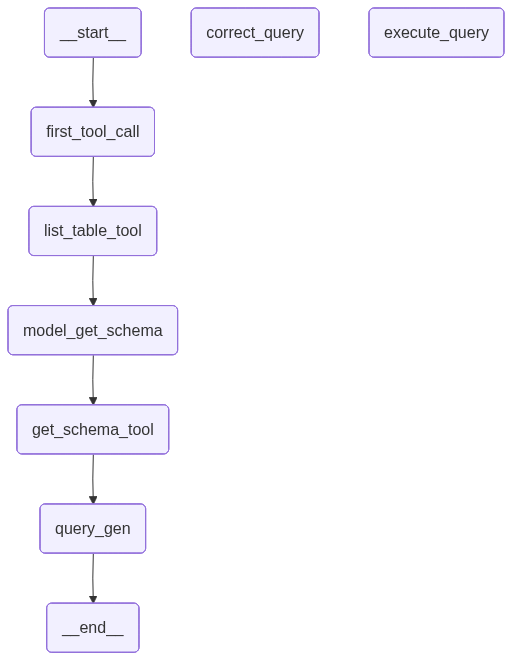

In [306]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [310]:
query = {"messages": [("user", "tell me the name of employee whos salary is more then 20000")]}

In [311]:
app.invoke(query)

{'messages': [HumanMessage(content='tell me the name of employee whos salary is more then 20000', additional_kwargs={}, response_metadata={}, id='c6066e68-dff3-4d0c-ba0d-68e3e69ed739'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='5b9d42e3-6287-446d-994a-71f047188b29', tool_calls=[{'name': 'sql_db_list_tables', 'args': {}, 'id': 'tool_abcd123', 'type': 'tool_call'}]),
  ToolMessage(content='customer, employee, orders', name='sql_db_list_tables', id='05dc12e6-0088-439b-b522-83a6bf42f628', tool_call_id='tool_abcd123'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '79mszv67e', 'function': {'arguments': '{"table_names":"employee"}', 'name': 'sql_db_schema'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 1037, 'total_tokens': 1072, 'completion_time': 0.068412711, 'prompt_time': 0.083553456, 'queue_time': 0.271031773, 'total_time': 0.151966167}, 'model_name': 'llama3-70b-8192', 'system_finger

In [ ]:
app.stream()

NameError: name 'app' is not defined